In [142]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

import cfl.util.brain_util as BU
import cfl.util.brain_vis as BV

In [143]:
###########READ IN Y DATA ############ 

Y = pd.read_csv('PTSD_Data_Share\Behavior_data\PTSD_PerLight.csv')

#split ID into one column for each variable 
new = Y["Animal ID"].str.split("_", n=3, expand=True)
Y[ "Genotype"] = new[1]
Y["Animal_Number"] = new[2]
Y["Timepoint"] = new[3]


#check for NaNs - dont find any
print(Y.isnull().values.any())

False


In [144]:
Y

,Animal ID,PerLight,Genotype,Animal_Number,Timepoint
0,PTSD_KO_03_BL,0.676965,KO,03,BL
1,PTSD_KO_03_PreF,0.159753,KO,03,PreF
2,PTSD_KO_03_Fear,0.280408,KO,03,Fear
3,PTSD_KO_03_D9,0.358919,KO,03,D9
4,PTSD_KO_04_BL,0.326555,KO,04,BL
...,...,...,...,...,...
74,PTSD_WT_11_D9,0.403257,WT,11,D9
75,PTSD_WT_12_BL,0.350375,WT,12,BL
76,PTSD_WT_12_PreF,0.273996,WT,12,PreF
77,PTSD_WT_12_Fear,0.243884,WT,12,Fear


In [145]:
################ PROCESSING Y DATA ##################
# add an entry for KO_04_D9 (the missing point) to make other operations easier
KO_04_D9_row = {"Genotype": "KO", "Animal_Number": "04", "Timepoint": "D9", "PerLight": np.NAN}
Y = Y.append(KO_04_D9_row, ignore_index=True)


#function to assign unique id number to each animal 
# so that ID numbers don't repeat between two animals 
# (the new id numbers go 0-19)
def assign_id(row): 
    if row['Genotype'] == "WT": 
        index = 10
    elif row['Genotype'] == "KO": 
        index = 0 
    index += int(row["Animal_Number"]) - 3 
    return index 

# create new column in dataframe
Y["ID"] = Y.apply(assign_id, axis=1)

# drop old ID column 
Y.drop(columns='Animal ID')

#reorder columns 
Y = Y.reindex(columns = ["ID", "Genotype", "Animal_Number", "Timepoint", "PerLight"])


In [146]:
Y

,ID,Genotype,Animal_Number,Timepoint,PerLight
0,0,KO,03,BL,0.676965
1,0,KO,03,PreF,0.159753
2,0,KO,03,Fear,0.280408
3,0,KO,03,D9,0.358919
4,1,KO,04,BL,0.326555
...,...,...,...,...,...
75,19,WT,12,BL,0.350375
76,19,WT,12,PreF,0.273996
77,19,WT,12,Fear,0.243884
78,19,WT,12,D9,0.377567


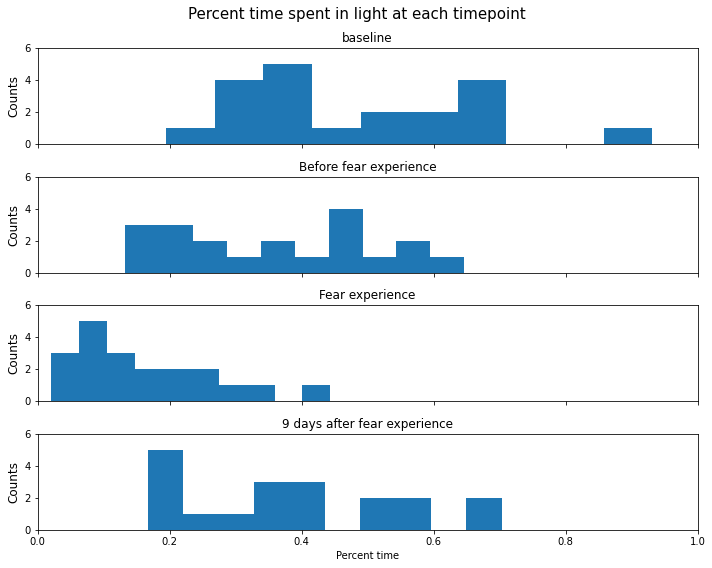

In [147]:
full_name = {"BL": "baseline", "PreF": "Before fear experience", "Fear":"Fear experience", "D9": "9 days after fear experience"}

fig, ax = plt.subplots(nrows=4, ncols=1, squeeze=False, figsize=(10, 8), sharex=True)
fig.suptitle("Percent time spent in light at each timepoint", fontsize=15)
timepoints = Y.Timepoint.unique()
for n, timepoint in enumerate(timepoints):
    ax[n, 0].hist(Y.loc[Y.Timepoint == timepoint]["PerLight"])
    ax[n, 0].title.set_text(full_name[timepoint])
    ax[n, 0].set_ylim(0, 6)
    ax[n, 0].set_ylabel("Counts", fontsize=12)

ax[3, 0].set_xlim(0, 1)
ax[3, 0].set_xlabel("Percent time")
plt.tight_layout()
plt.show()

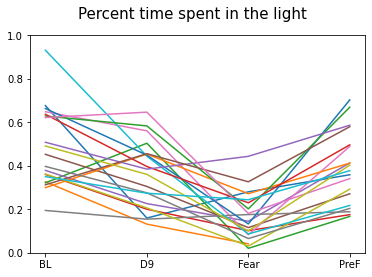

In [148]:
timepoints = np.unique(Y["Timepoint"])

fig, ax = plt.subplots()
for i in range(20): 
    ax.plot(timepoints, Y.loc[(Y.ID==i), "PerLight"], label=str(Y.ID))
fig.suptitle("Percent time spent in the light", fontsize=15)

ax.set_ylim(0, 1)
fig.show()

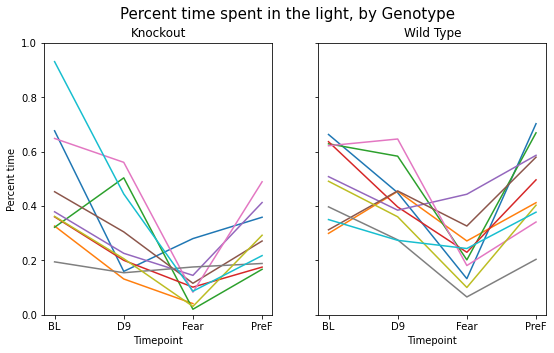

In [149]:
timepoints = np.unique(Y["Timepoint"])

fig, ax = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
for i in range(20): 
    #plot KO subplot
    selection1 = Y.loc[(Y.ID==i) & (Y.Genotype=="KO"), "PerLight"]
    if not selection1.empty: 
        ax[0].plot(timepoints, selection1, label=str(Y.ID))
    #plot WT subplot 
    selection2 = Y.loc[(Y.ID==i) & (Y.Genotype=="WT"), "PerLight"]
    if not selection2.empty: 
        ax[1].plot(timepoints, selection2, label=str(Y.ID))

ax[0].set_ylim(0, 1)
ax[0].set_title("Knockout")
ax[1].set_title("Wild Type")
ax[0].set_ylabel("Percent time")
ax[0].set_xlabel("Timepoint")
ax[1].set_xlabel("Timepoint")
fig.suptitle("Percent time spent in the light, by Genotype", fontsize=15)
fig.show()


#TODO: timepoints backwards 

In [150]:
behav_csv = 'PTSD_Data_Share\Behavior_data\PTSD_PerLight.csv'
mri_dir = 'PTSD_Data_Share\MEMRI_data'

In [151]:
# The images start out in RPS orientation
nib_loaded_img = nib.load(os.path.join(mri_dir, "PTSD_KO_03_BL.nii"))
nib.orientations.aff2axcodes(nib_loaded_img.affine)

('R', 'P', 'S')

In [152]:
# load one image, in RAS orientation
img = BU.load_brain(os.path.join(mri_dir, "PTSD_KO_03_BL.nii"), ori='RAS')

#view its dimensions
mri_dims = img.shape
mri_dims

(124, 200, 82)

In [174]:
124*100*82

1016800

In [153]:
# load all the images in RAS orientation 
X, Y_unused = BU.load_data(mri_dir, behav_csv, mri_dims, ori='RAS')

In [154]:
#check all images are the same shape 
for fp in os.listdir(mri_dir):
    full_path = os.path.join(mri_dir, fp)
    brain = BU.load_brain(full_path)
    assert brain.shape ==  mri_dims
    #print(brain.shape)

In [155]:
np.all(np.equal(brain[5], 0) ) # brain[5] = a slice of image near the end, with no brain in it

#when there's nothing present in the image, that is represented by a 0 

True

# Load Mask 

In [156]:
# load the non-linear mask template
nl_mask_path = os.path.join('PTSD_Data_Share/templates\MuseTemplate_nonlinear_mask.nii')
nl_mask = BU.load_brain(nl_mask_path)
nolin_mask_vec = BU.flatten(nl_mask)


In [157]:
nl_mask.shape == mri_dims #mask has same dims as other images

True

In [158]:
# specify labels for plot (note the labels below are specifically for RAS orientation)
dir_labels = { 'saggital' :   ['P', 'A', 'D', 'V'],
               'coronal' :    ['L', 'R', 'D', 'V'],
               'horizontal' : ['L', 'R', 'A', 'P']} 
# generate interactive plots
BV.plot_interactive_panels(BU.flatten(img), mri_dims, nolin_mask_vec, figsize=(10,3), std_scale='std', dir_labels=dir_labels)

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=123, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=199, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=81, step=5), Output…

In [159]:
# load the non-linear mask template
l_mask_path = os.path.join('PTSD_Data_Share/templates\MuseTemplate_linear_mask.nii')
l_mask = BU.load_brain(l_mask_path)
lin_mask_vec = BU.flatten(l_mask)


In [160]:
l_mask.shape == mri_dims #mask has same dims as other images

True

In [161]:
# specify labels for plot (note the labels below are specifically for RAS orientation)
dir_labels = { 'saggital' :   ['P', 'A', 'D', 'V'],
               'coronal' :    ['L', 'R', 'D', 'V'],
               'horizontal' : ['L', 'R', 'A', 'P']} 
# generate interactive plots
BV.plot_interactive_panels(BU.flatten(img), mri_dims, lin_mask_vec, figsize=(3,3), std_scale='std', dir_labels=dir_labels)

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=123, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=199, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=81, step=5), Output…

In [162]:
BV.plot_interactive_panels(X[:5], mri_dims, nolin_mask_vec, dir_labels, figsize=(16,3))


interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=123, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=199, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=81, step=5), Output…

In [163]:
# how many voxels are unmasked? 
print("Non-linear mask: ", np.sum(nolin_mask_vec==1))
print("Linear mask: ", np.sum(lin_mask_vec==1))

Non-linear mask:  531632
Linear mask:  482793


# Heatmap 

## Heatmap of all the brains aggregated together 

In [164]:
# from tqdm import tqdm 

# heatmap = np.zeros(np.prod(mri_dims))
# for brain in tqdm(X):
#     heatmap += brain
    
# np.save(os.path.join('heatmap.npy'), heatmap)

In [165]:
heatmap = np.load(os.path.join('heatmap.npy'))
BV.plot_interactive_panels(heatmap, mri_dims, nolin_mask_vec, figsize=(10, 5), std_scale=True, dir_labels=dir_labels)

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=123, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=199, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=81, step=5), Output…

## Heatmap of the WT vs KO mice broken out

In [166]:
# WT_indices = Y[Y["Genotype"]=="WT"].index.tolist()
# KO_indices = Y.dropna(how='any', axis=0)[Y["Genotype"]=="KO"].index.tolist() #remove last value bc it doesn't have an associated MRI 

# heatmap_WT = np.zeros(np.prod(mri_dims))
# for brain in tqdm(X[WT_indices]):
#     heatmap_WT += brain
    
# np.save(os.path.join('heatmap_WT.npy'), heatmap)

# heatmap_KO = np.zeros(np.prod(mri_dims))
# for brain in tqdm(X[KO_indices]):
#     heatmap_KO += brain
    
# np.save(os.path.join('heatmap_KO.npy'), heatmap)

In [167]:
heatmap_WT = np.load(os.path.join('heatmap_WT.npy'))
heatmap_KO = np.load(os.path.join('heatmap_KO.npy'))

BV.plot_interactive_panels(np.vstack((heatmap_WT, heatmap_KO)), mri_dims, nolin_mask_vec, figsize=(10, 5), std_scale=True, dir_labels=dir_labels, column_titles=["Wild-type", "Knockout"])

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=123, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=199, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=81, step=5), Output…

## Heatmap with each timepoint broken out 

In [168]:
baseline_indices = Y[Y["Timepoint"]=="BL"].index.tolist()
prefear_indices = Y[Y["Timepoint"]=="PreF"].index.tolist()
postfear_indices = Y[Y["Timepoint"]=="Fear"].index.tolist()
d9_indices = Y.dropna(how='any', axis=0)[Y["Timepoint"]=="D9"].index.tolist() 
timepoints_dir = {'BL' : baseline_indices, 'PreF': prefear_indices, "Fear": postfear_indices, 'D9': d9_indices}

# HM_list = [] 
# for timepoint in timepoints_dir: 
#     currentHM = np.zeros(np.prod(mri_dims))
#     indices = timepoints_dir[timepoint]
#     for brain in tqdm(X[indices]):
#         currentHM += brain
#     HM_list.append(currentHM)

#     save_name = 'heatmap_' + timepoint + '.npy'
#     np.save(os.path.join(save_name), currentHM) 

In [169]:
heatmap_names = ['heatmap_' + str(timepoint) for timepoint in timepoints_dir.keys()]

HM_list = []
for heatmap in heatmap_names: 
    HM_list.append(np.load(heatmap + '.npy'))


BV.plot_interactive_panels(np.vstack(HM_list), mri_dims, nolin_mask_vec, figsize=(12, 3), std_scale=True, dir_labels=dir_labels, column_titles=list(timepoints_dir))

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=123, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=199, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=81, step=5), Output…

From the readme: 

"BL, baseline, brain images do not have any Mn(II) and thus are not enhanced. They are the baseline structural images that we compare our Mn(II)-enhanced (PreF, Fear, D9) images to."

All the images are normalized along the same scale 
My interpretation: The Baseline images are in general somewhat darker red than the other images because the range of values they take on, from no activity to peak activity, is much smaller, so the 'low activity'/'normal' states have a higher numeric value after normalization compared to in the other images. 

"Overall, the greater in magnitude the voxel intensity value of a contrast enhanced image comparing to each animal's baseline non-contrast enhanced image, corresponds to greater Mn(II) accumulation i.e. neural activity in a particular cluster of voxels."

From this statement, I think they may be saving that we should analyze the intensity in a pre-fear/fear/D9 image minus the intensity in the baseline image, in order to find spikes in activity? 

## Heatmap of each timepoint, adjusted by baseline intensity 

In [170]:
HM_dir = {'PreF': np.zeros(np.prod(mri_dims)), "Fear": np.zeros(np.prod(mri_dims)), 'D9': np.zeros(np.prod(mri_dims))}
all_mouse_indices = pd.unique(Y["ID"])

# for each mouse....
for mouse_id in all_mouse_indices:
    this_mouses_data = Y.dropna(how='any', axis=0)[Y["ID"]==mouse_id] 
    # find its associated baseline 
    baseline_index = this_mouses_data[this_mouses_data.Timepoint == "BL"].index[0]
    baseline_image = X[baseline_index]
    # for each timepoint that the mouse has... 
    mouses_timepoints = this_mouses_data.Timepoint.tolist()
    mouses_timepoints.remove('BL')
    for timepoint in mouses_timepoints:
        # get the image associated with that timepoint, subtract off the baseline
        curr_mri_index = this_mouses_data.index[this_mouses_data.Timepoint==timepoint][0]
        adjusted_mri = X[curr_mri_index] - baseline_image

        # add the result to the correct heatmap entry 
        HM_dir[timepoint] += adjusted_mri

In [171]:
BV.plot_interactive_panels(np.vstack(list(HM_dir.values())), mri_dims, nolin_mask_vec, figsize=(12, 3), std_scale=True, dir_labels=dir_labels, column_titles=list(HM_dir.keys()))

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=123, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=199, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=81, step=5), Output…

 ## Correlation between each voxel of brains and Y (percent time spent in the light)

I'm not sure whether I should be calculating the correlation relative to the images plain, or after adjusting

In [172]:
sanity_check = np.zeros((n_components, X.shape[1]))
for i in range(n_components):
    for j in range(X.shape[1]):
        sanity_check[i,j] = pearsonr(X[:,j], Y[:,i])[0]

NameError: name 'n_components' is not defined

In [139]:
from scipy.stats import pearsonr

attempt = np.zeros(np.prod(mri_dims))
for i in range(np.prod(mri_dims)): 
        attempt[i] = pearsonr(X[:,i], Y.PerLight[:79].tolist())[0]

np.save(os.path.join('correlations.npy'), attempt)

In [141]:
# attempt = np.load('correlations.npy')
BV.plot_interactive_panels(attempt, mri_dims, nolin_mask_vec, figsize=(5,3), std_scale='corr', dir_labels=dir_labels)

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=123, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=199, step=5), Outpu…

interactive(children=(IntSlider(value=0, continuous_update=False, description='slice', max=81, step=5), Output…

In [ ]:
# write a function that takes in ID and timepoint and returns the  

In [ ]:
# coarsen brains to ~1000ish voxels
# (this mri has diff problems than current coarsening code - how to deal with edges)
# how does subtracting out baseline affect images (artifacts, etc) 

# subtract baseline behavior from fear ?  ---> this would lead to only 20 samples 
# difference in fear compared to difference in brain activation 